<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/FirstCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Our first CNN!

Here we have some helper functions for normalizing and standardizing our data using numpy.

In [ ]:
import numpy as np

def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

def min_max_scale(da):
    """
    Scale training data by minimum and maximum values.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.min(da)) / (np.max(da) - np.min(da))

## **Supervised Learning Regression Example**

Now, we will proceed with training a neural network in a supervised learning regression application.

We will use a dataset from Molina et al. (2021) consisting of thunderstorms generated using a 4-km horizontal resolution WRF simulation. We are using a small portion of the dataset, specifically thunderstorms simulated for April 27, 2011 over the continental United States.

In [2]:
!wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc

--2025-03-06 12:49:45--  https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109400556 (104M) [application/octet-stream]
Saving to: ‘current_SP3hourly_20110427.nc.1’

current_SP3hourly_2 100%[===================>] 104.33M  19.8MB/s    in 6.2s    

2025-03-06 12:49:53 (16.9 MB/s) - ‘current_SP3hourly_20110427.nc.1’ saved [109400556/109400556]



Let's visualize the dataset. We can use python libraries for this.

In [3]:
import matplotlib.pyplot as plt
import xarray as xr

In [4]:
ds = xr.open_dataset('current_SP3hourly_20110427.nc')

In [5]:
ds

<xarray.Dataset> Size: 109MB
Dimensions:      (starttime: 2224, y: 32, x: 32)
Coordinates:
  * starttime    (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime      (starttime) float64 18kB ...
    x_speed      (starttime) int64 18kB ...
    y_speed      (starttime) int64 18kB ...
Dimensions without coordinates: y, x
Data variables:
    uh25_grid    (starttime, y, x) float32 9MB ...
    uh03_grid    (starttime, y, x) float32 9MB ...
    ctt_grid     (starttime, y, x) float32 9MB ...
    dbz_grid     (starttime, y, x) float32 9MB ...
    mask         (starttime, y, x) int64 18MB ...
    row_indices  (starttime, y, x) int64 18MB ...
    col_indices  (starttime, y, x) int64 18MB ...
    lats         (starttime, y, x) float32 9MB ...
    lons         (starttime, y, x) float32 9MB ...

The dataset contains 2,224 storm samples that were generated using the github reposity [deep-conus](https://github.com/mariajmolina/deep-conus). Each sample is 32x32 grid cells (i.e., pixels) with each grid cell spanning 4-km.

Let's visualize some of the variables.

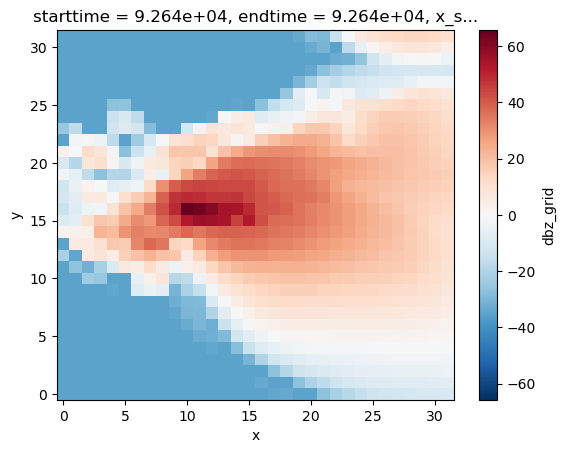

In [9]:
# simulated radar reflectivity
ds['dbz_grid'].isel(starttime=0).plot()
plt.show()

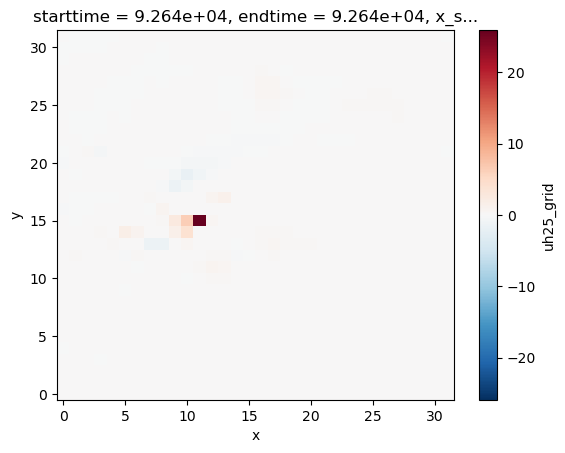

In [10]:
# gridded updraft helicity from 2-5 km
ds['uh25_grid'].isel(starttime=0).plot()
plt.show()

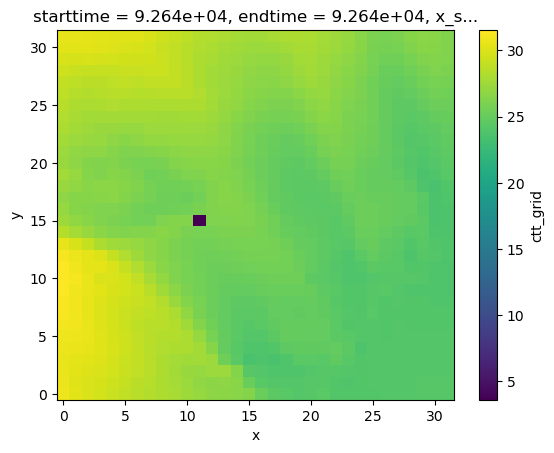

In [11]:
# gridded cloud top temperature
ds['ctt_grid'].isel(starttime=0).plot()
plt.show()

Now we will preprocess our training and testing data. We need to split our data into a training and testing sets, and standardize.

In [12]:
def random_split(data, label, split=0.3, seed=0):
    """
    Help spliting data randomly for training and testing.
    """
    np.random.seed(0)
    da_indx = np.random.permutation(data.shape[0])
    data  = data[da_indx.astype(int)]
    label = label[da_indx.astype(int)]
    init_range = int(data.shape[0] * (1 - 0.3))
    return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
features = xr.concat([
    ds['dbz_grid'].expand_dims(dim='feature', axis=3),
    ds['ctt_grid'].expand_dims(dim='feature', axis=3)],
          dim='feature')

In [14]:
print(features.shape)

(2224, 32, 32, 2)


In [15]:
# grab the maximum of the dbz to use as our labels (regression)
labels = ds['dbz_grid'].expand_dims(dim='feature', axis=3).max('x').max('y')

In [16]:
print(labels)

<xarray.DataArray 'dbz_grid' (starttime: 2224, feature: 1)> Size: 9kB
array([[65.721054],
       [58.54062 ],
       [58.54062 ],
       ...,
       [45.41483 ],
       [37.786957],
       [42.48563 ]], dtype=float32)
Coordinates:
  * starttime  (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime    (starttime) float64 18kB ...
    x_speed    (starttime) int64 18kB ...
    y_speed    (starttime) int64 18kB ...
Dimensions without coordinates: feature


In [17]:
train_feats, train_label, test_feats, test_label = random_split(features, labels)

In [18]:
print(train_feats.shape[0], train_label.shape[0], test_feats.shape[0], test_label.shape[0])

1556 1556 668 668


In [72]:
# normalization of our training data (note each feature individually processed!)
train_feats_standardized = xr.concat([
    z_score(train_feats.isel(feature=0).expand_dims(dim='feature', axis=3)),
    z_score(train_feats.isel(feature=1).expand_dims(dim='feature', axis=3))],
                                     dim='feature')

train_label_standardized = z_score(train_label)

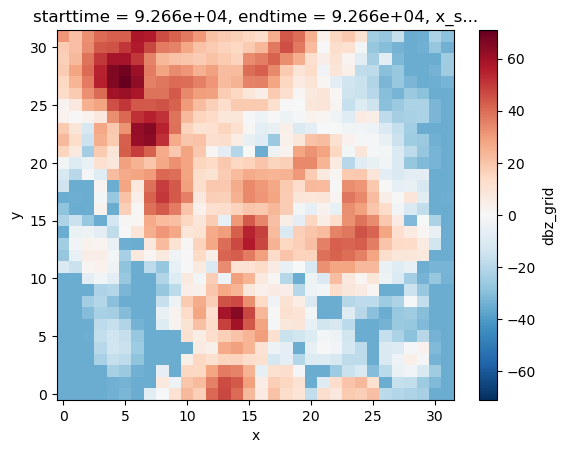

In [73]:
train_feats.isel(feature=0,starttime=15).plot()
plt.show()

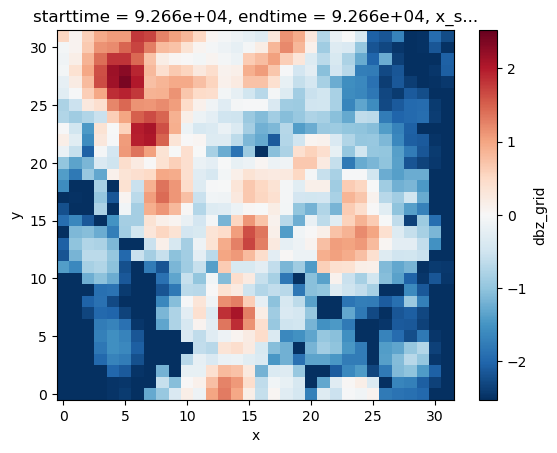

In [74]:
train_feats_standardized.isel(feature=0,starttime=15).plot()
plt.show()

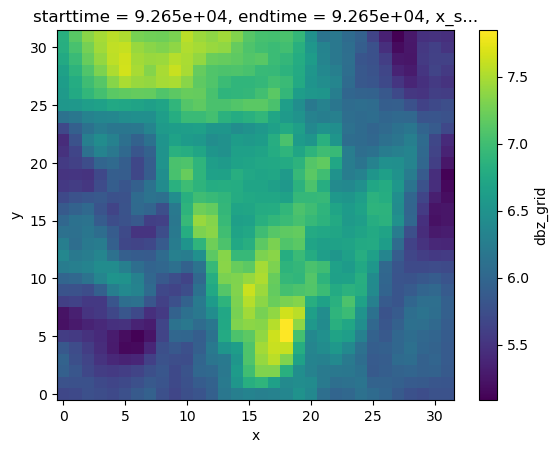

In [75]:
train_feats.isel(feature=1,starttime=100).plot()
plt.show()

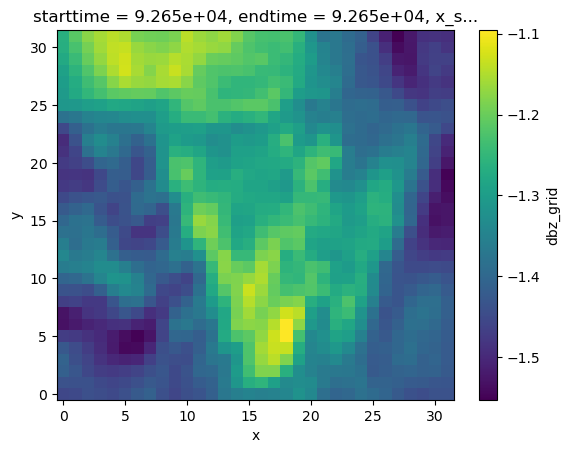

In [76]:
train_feats_standardized.isel(feature=1,starttime=100).plot()
plt.show()

Let's proceed to build a simple convolutional neural network that will take images as the input and predict the respective storm's maximum updraft helicity.

In [77]:
import keras
from keras import layers

In [78]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

In [79]:
# lets use two input variables (dbz_grid and ctt_grid)
number_of_features = 2

In [194]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

# data augmentation layers
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

# hidden layers
model.add(layers.Conv2D(64, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

# Now that we have 4x4 feature maps, now apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add last fully connected (dense) layers
model.add(layers.Dense(4))
model.add(layers.Dense(1, activation="linear"))

# print model summary
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 32, 32, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 32, 32, 2)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 64)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_14         │ (None, 16)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,377 (95.22 KB)

 Trainable params: 24,377 (95.22 KB)

 Non-trainable params: 0 (0.00 B)

Proceeding with compiling our model and selecting some metrics to use.

Some common evaluation metrics used with regression problems are:

Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$

Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$


More evalution metrics can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [195]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

In [196]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

In [197]:
BATCH_SIZE = 32
EPOCHS = 10

In [198]:
history = model.fit(
    x=train_feats_standardized.values,
    y=train_label_standardized.values,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.6937 - mean_squared_error: 0.6937 - root_mean_squared_error: 0.8318 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - val_root_mean_squared_error: 0.8025
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4778 - mean_squared_error: 0.4778 - root_mean_squared_error: 0.6909 - val_loss: 0.4684 - val_mean_squared_error: 0.4684 - val_root_mean_squared_error: 0.6844
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3863 - mean_squared_error: 0.3863 - root_mean_squared_error: 0.6211 - val_loss: 0.3379 - val_mean_squared_error: 0.3379 - val_root_mean_squared_error: 0.5813
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2888 - mean_squared_error: 0.2888 - root_mean_squared_error: 0.5369 - val_loss: 0.2740 - val_mean_squared_error: 0.2740 - val_root_mean_squared_error: 0.5235
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2326 - mean_squared_error: 0.2326 - root_mean_squared_error: 0.

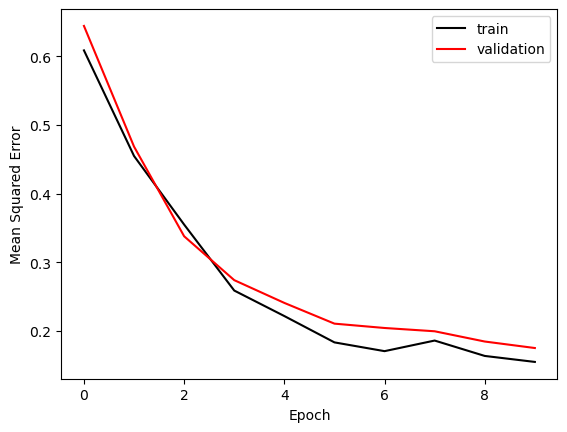

In [199]:
plt.plot(history.history["mean_squared_error"], c='k', label='train')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Lets now evaluate the model using the test dataset. We need to standardize the data, but using the mean and standard deviation of the training set.

In [200]:
def z_score_testing(da, testdata):
    """
    Compute z-score for testing data.
    Args:
        da (array): Array of training variable.
    """
    return (testdata - np.mean(da)) / np.std(da)

In [201]:
# normalization of our training data (note each feature individually processed!)
test_feats_standardized = xr.concat([
    z_score_testing(
        train_feats.isel(feature=0).expand_dims(dim='feature', axis=3),
        test_feats.isel(feature=0).expand_dims(dim='feature', axis=3)
        ),
    z_score_testing(
        train_feats.isel(feature=1).expand_dims(dim='feature', axis=3),
        test_feats.isel(feature=1).expand_dims(dim='feature', axis=3)
        )],
                                     dim='feature')

test_label_standardized = z_score_testing(train_label, test_label)

In [202]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_feats_standardized.values, test_label_standardized.values, batch_size=128)
print(results)

Evaluate on test data
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1787 - mean_squared_error: 0.1787 - root_mean_squared_error: 0.4226
[0.1815560907125473, 0.1815560907125473, 0.4260939955711365]


In [203]:
# generate predictions using the trained model
predictions = model.predict(test_feats_standardized.values)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


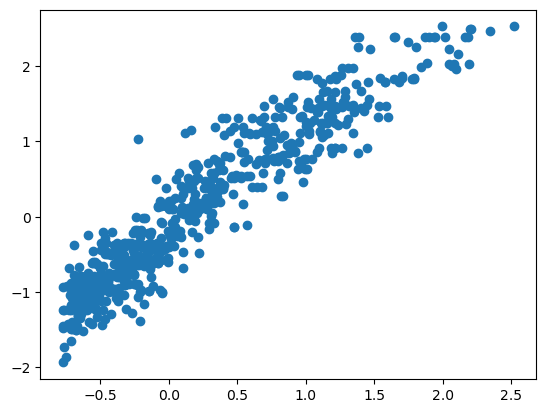

In [204]:
# visualize predictions vs ground truth
plt.scatter(predictions, test_label_standardized.values)
plt.show()

# Tutorial Practice: How does batch size impact model training?

---

In [ ]:
# recreate the model object

In [ ]:
# recompile the model

In [ ]:
# retrain the model

In [ ]:
# evaluate the new model's skill

Other sample questions for practice:

*   How does the learning rate impact model training?
*   Does data augmentation help with model skill?
*   Does reducing regularization impact overfitting (hint: reduce dropout percentage)?

In [ ]:
# more cells for practicing

# Supervised Learning Classification Example

---

Using our work from the previous section, we will now use the data and reframe our problem to be a classification task. As before, we will use two input features.

However, we will use updraft helicity values (which represent storm updraft rotation) and convert this continuous value into two classes, "not potentially severe" and "potentially severe". More strongly rotating storms have a greater likelihood of producing severe hazards like tornadoes and large hail. We will use 75 m2/s2 as the delineation mark between the two classes. The two classes will be creating using integer encoding first, with 0 representing non-severe and 1 representing potentially severe, and then converting using one-hot encoding for subsequent training.

In [ ]:
features = xr.concat([
    ds['dbz_grid'].expand_dims(dim='feature', axis=3),
    ds['ctt_grid'].expand_dims(dim='feature', axis=3)],
          dim='feature')

labels = ds['uh25_grid'].expand_dims(dim='feature', axis=3).max('x').max('y')

train_feats, train_label, test_feats, test_label = random_split(features, labels)

# normalization of our training data (note each feature individually processed!)
train_feats_standardized = xr.concat([
    z_score(train_feats.isel(feature=0).expand_dims(dim='feature', axis=3)),
    z_score(train_feats.isel(feature=1).expand_dims(dim='feature', axis=3))],
                                     dim='feature')

train_label_ints = xr.where(train_label >= 75, 1, 0)

In [ ]:
print(train_label.values[-2:])
print(train_label_ints.values[-2:])

[[162.55905  ]
 [  1.8748366]]
[[1]
 [0]]


In [ ]:
# convert labels into classes using one-hot encoding
onehot_layer = keras.layers.CategoryEncoding(num_tokens=2, output_mode="one_hot")
train_y = onehot_layer(train_label_ints.astype(int))

In [ ]:
train_y[-2:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.]], dtype=float32)>

In [ ]:
# out of more than 1000 samples, only 189 are the "severe" class
print(train_y[:,1].numpy().sum())
print(train_y[:,1].numpy().shape)

189.0
(1556,)


Class imbalance is a major issue with a minority class that is a rare event, like severe hazards. To address this limitation, we create class weights that help the machine learning model learn that the minority class is important to get correct.

In [ ]:
# generate class weights due to class imbalance issues
# use the second class as the positive one (using 1 index)
counts = np.bincount(train_y[:,1].numpy().astype(int))

print("Number of positive samples in training data: {} ({:.2f}% of total)".format(
    counts[1], 100 * float(counts[1]) / len(train_y)))

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

Number of positive samples in training data: 189 (12.15% of total)
{0: 0.000731528895391368, 1: 0.005291005291005291}


In [ ]:
# metrics that are useful for classification, particularly for two classes
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

# data augmentation layers
#model.add(layers.RandomFlip("horizontal_and_vertical"))
#model.add(layers.RandomRotation(factor=(-0.5,0.5)))

# hidden layers
model.add(layers.Conv2D(32, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

# Now that we have 4x4 feature maps, now apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add last fully connected (dense) layers
model.add(layers.Dense(64))
model.add(layers.Dense(2, activation="softmax"))

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        608       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)         

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(), # categorical loss function
    metrics=METRICS
)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
print("Fit model on training data")
history = model.fit(
    x=train_feats_standardized.values,
    y=train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
    class_weight=class_weight,
)

Fit model on training data
Epoch 1/10
44/44 [==============================] - 8s 127ms/step - loss: 7.3008e-04 - cross entropy: 0.6251 - tp: 778.0000 - fp: 622.0000 - tn: 778.0000 - fn: 622.0000 - accuracy: 0.5557 - precision: 0.5557 - recall: 0.5557 - auc: 0.6789 - prc: 0.7216 - val_loss: 0.5818 - val_cross entropy: 0.5818 - val_tp: 83.0000 - val_fp: 73.0000 - val_tn: 83.0000 - val_fn: 73.0000 - val_accuracy: 0.5321 - val_precision: 0.5321 - val_recall: 0.5321 - val_auc: 0.7129 - val_prc: 0.7584
Epoch 2/10
44/44 [==============================] - 4s 99ms/step - loss: 5.8429e-04 - cross entropy: 0.5035 - tp: 947.0000 - fp: 453.0000 - tn: 947.0000 - fn: 453.0000 - accuracy: 0.6764 - precision: 0.6764 - recall: 0.6764 - auc: 0.8062 - prc: 0.8262 - val_loss: 0.4368 - val_cross entropy: 0.4368 - val_tp: 121.0000 - val_fp: 35.0000 - val_tn: 121.0000 - val_fn: 35.0000 - val_accuracy: 0.7756 - val_precision: 0.7756 - val_recall: 0.7756 - val_auc: 0.8727 - val_prc: 0.8823
Epoch 3/10
44/44 [==

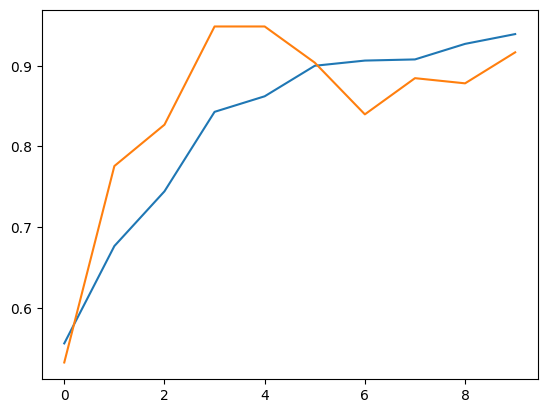

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# normalization of our training data (note each feature individually processed!)
test_feats_standardized = xr.concat([
    z_score_testing(
        train_feats.isel(feature=0).expand_dims(dim='feature', axis=3),
        test_feats.isel(feature=0).expand_dims(dim='feature', axis=3)
        ),
    z_score_testing(
        train_feats.isel(feature=1).expand_dims(dim='feature', axis=3),
        test_feats.isel(feature=1).expand_dims(dim='feature', axis=3)
        )],
                                     dim='feature')

test_label_ints = xr.where(test_label >= 75, 1, 0)
test_y = onehot_layer(test_label_ints.astype(int))

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_feats_standardized.values, test_y, batch_size=128)
print(results)

Evaluate on test data
6/6 [==============================] - 0s 70ms/step - loss: 0.2836 - cross entropy: 0.2836 - tp: 605.0000 - fp: 63.0000 - tn: 605.0000 - fn: 63.0000 - accuracy: 0.9057 - precision: 0.9057 - recall: 0.9057 - auc: 0.9548 - prc: 0.9461
[0.28363198041915894, 0.28363198041915894, 605.0, 63.0, 605.0, 63.0, 0.9056886434555054, 0.9056886434555054, 0.9056886434555054, 0.954757034778595, 0.946064293384552]


In [ ]:
# generate predictions using the trained model
predictions = model.predict(test_feats_standardized.values)

21/21 [==============================] - 1s 21ms/step


In [ ]:
pred_ints = xr.where(predictions[:,1]>0.5, 1, 0)

In [ ]:
from sklearn.metrics.cluster import contingency_matrix
contingency_matrix(test_label_ints.astype(int).values.squeeze(), pred_ints)
# tend to predict more false positives

array([[515,  61],
       [  2,  90]])

In [ ]:
test_label_ints.astype(int).sum().values

array(92)

In [ ]:
pred_ints.sum() - 92

59

# Tutorial Practice: What happens if we do not use class weights during training?

---

In [ ]:
# recreate the model object

In [ ]:
# recompile the model

In [ ]:
# retrain the model without class weights

In [ ]:
# evaluate the new model's skill

# References

Campbell, T., G. M. Lackmann, M. J. Molina, and M. D. Parker (2024). Severe Convective Storms in Limited Instability Organized by Pattern and Distribution. Weather and Forecasting. https://journals.ametsoc.org/view/journals/wefo/39/1/WAF-D-23-0130.1.xml

DuVivier, A. K., M. J. Molina, A. L. Deppenmeier, M. M. Holland, L. Landrum, K. Krumhardt, and S. Jenouvrier (2023). Projections of Winter Polynyas and Their Biophysical Impacts in the Ross Sea Antarctica. Climate Dynamics. https://link.springer.com/article/10.1007/s00382-023-06951-z

Molina, M. J., D. J. Gagne, and A. F. Prein (2021). A benchmark to test generalization capabilities of deep learning methods to classify severe convective storms in a changing climate. Earth and Space Science. https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020EA001490

Molina, M. J., T. A. O'Brien, G. Anderson, M. Ashfaq, K. E. Bennett, W. D. Collins, K. Dagon, J. M. Restrepo, and P. A. Ullrich (2023). A Review of Recent and Emerging Machine Learning Applications for Climate Variability and Weather Phenomena. Artificial Intelligence for the Earth Systems. https://journals.ametsoc.org/view/journals/aies/2/4/AIES-D-22-0086.1.xml

Molina, M. J., J. H. Richter, A. A. Glanville, K. Dagon, J. Berner, A. Hu, and G. A. Meehl (2023). Subseasonal Representation and Predictability of North American Weather Regimes using Cluster Analysis. Artificial Intelligence for the Earth Systems. https://journals.ametsoc.org/view/journals/aies/2/2/AIES-D-22-0051.1.xml

Passarella, L.S. and Mahajan, S., 2023. Assessing Tropical Pacific–Induced Predictability of Southern California Precipitation Using a Novel Multi-Input Multioutput Autoencoder. Artificial Intelligence for the Earth Systems, 2(4), p.e230003. https://journals.ametsoc.org/view/journals/aies/2/4/AIES-D-23-0003.1.xml